In [1]:
"""Summary of tensorflow basics.

Parag K. Mital, Jan 2016."""

'Summary of tensorflow basics.\n\nParag K. Mital, Jan 2016.'

In [2]:
# %% Import tensorflow and pyplot
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# %% tf.Graph represents a collection of tf.Operations
# You can create operations by writing out equations.
# By default, there is a graph: tf.get_default_graph()
# and any new operations are added to this graph.
# The result of a tf.Operation is a tf.Tensor, which holds
# the values.

In [4]:
# %% First a tf.Tensor
n_values = 32
x = tf.linspace(-3.0, 3.0, n_values)

In [5]:
# %% Construct a tf.Session to execute the graph.
sess = tf.Session()
result = sess.run(x)

In [6]:
# %% Alternatively pass a session to the eval fn:
x.eval(session=sess)
# x.eval() does not work, as it requires a session!

array([-3.        , -2.8064516 , -2.612903  , -2.419355  , -2.2258065 ,
       -2.032258  , -1.8387097 , -1.6451614 , -1.451613  , -1.2580645 ,
       -1.0645162 , -0.8709678 , -0.6774194 , -0.48387104, -0.29032266,
       -0.09677428,  0.0967741 ,  0.29032248,  0.48387086,  0.67741925,
        0.8709676 ,  1.0645161 ,  1.2580644 ,  1.4516127 ,  1.6451612 ,
        1.8387096 ,  2.032258  ,  2.2258062 ,  2.4193547 ,  2.612903  ,
        2.8064513 ,  2.9999998 ], dtype=float32)

In [7]:
# %% We can setup an interactive session if we don't
# want to keep passing the session around:
sess.close()
sess = tf.InteractiveSession()

In [8]:
# %% Now this will work!
x.eval()

array([-3.        , -2.8064516 , -2.612903  , -2.419355  , -2.2258065 ,
       -2.032258  , -1.8387097 , -1.6451614 , -1.451613  , -1.2580645 ,
       -1.0645162 , -0.8709678 , -0.6774194 , -0.48387104, -0.29032266,
       -0.09677428,  0.0967741 ,  0.29032248,  0.48387086,  0.67741925,
        0.8709676 ,  1.0645161 ,  1.2580644 ,  1.4516127 ,  1.6451612 ,
        1.8387096 ,  2.032258  ,  2.2258062 ,  2.4193547 ,  2.612903  ,
        2.8064513 ,  2.9999998 ], dtype=float32)

In [9]:
# %% Now a tf.Operation
# We'll use our values from [-3, 3] to create a Gaussian Distribution
sigma = 1.0
mean = 0.0
z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                   (2.0 * tf.pow(sigma, 2.0)))) *
     (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))

In [10]:
# %% By default, new operations are added to the default Graph
assert z.graph is tf.get_default_graph()

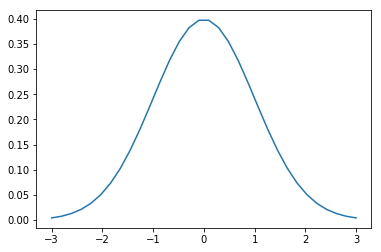

In [11]:
# %% Execute the graph and plot the result
plt.plot(x.eval(), z.eval())
plt.show()

In [12]:
# %% We can find out the shape of a tensor like so:
print(z.get_shape())

(32,)


In [13]:
# %% Or in a more friendly format
print(z.get_shape().as_list())

[32]


In [14]:
# %% Sometimes we may not know the shape of a tensor
# until it is computed in the graph.  In that case
# we should use the tf.shape fn, which will return a
# Tensor which can be eval'ed, rather than a discrete
# value of tf.Dimension
print(tf.shape(z).eval())

[32]


In [15]:
# %% We can combine tensors like so:
print(tf.stack([tf.shape(z), tf.shape(z), [3], [4]]).eval())

[[32]
 [32]
 [ 3]
 [ 4]]


In [16]:
# %% Let's multiply the two to get a 2d gaussian
z_2d = tf.matmul(tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))

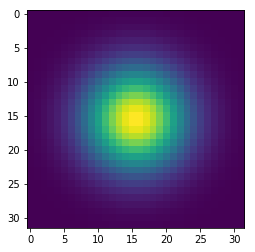

In [17]:
# %% Execute the graph and store the value that `out` represents in `result`.
plt.imshow(z_2d.eval())
plt.show()

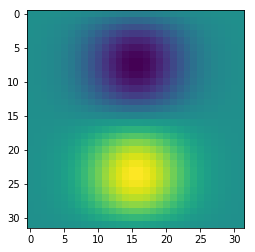

In [18]:
# %% For fun let's create a gabor patch:
x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
y = tf.reshape(tf.ones_like(x), [1, n_values])
z = tf.matmul(tf.matmul(x, y), z_2d)
plt.imshow(z.eval())
plt.show()

In [19]:
# %% We can also list all the operations of a graph:
ops = tf.get_default_graph().get_operations()
print([op.name for op in ops])

['LinSpace/start', 'LinSpace/stop', 'LinSpace/num', 'LinSpace', 'sub/y', 'sub', 'Pow/y', 'Pow', 'Pow_1/x', 'Pow_1/y', 'Pow_1', 'mul/x', 'mul', 'truediv', 'Neg', 'Exp', 'Sqrt/x', 'Sqrt', 'mul_1/x', 'mul_1', 'truediv_1/x', 'truediv_1', 'mul_2', 'Shape', 'Shape_1', 'Shape_2', 'stack/2_1', 'stack/3_1', 'stack', 'Reshape/shape', 'Reshape', 'Reshape_1/shape', 'Reshape_1', 'MatMul', 'LinSpace_1/start', 'LinSpace_1/stop', 'LinSpace_1/num', 'LinSpace_1', 'Sin', 'Reshape_2/shape', 'Reshape_2', 'ones_like/Shape', 'ones_like/Const', 'ones_like', 'Reshape_3/shape', 'Reshape_3', 'MatMul_1', 'MatMul_2']


In [20]:
# %% Lets try creating a generic function for computing the same thing:
def gabor(n_values=32, sigma=1.0, mean=0.0):
    x = tf.linspace(-3.0, 3.0, n_values)
    z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                       (2.0 * tf.pow(sigma, 2.0)))) *
         (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
    gauss_kernel = tf.matmul(
        tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))
    x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
    y = tf.reshape(tf.ones_like(x), [1, n_values])
    gabor_kernel = tf.matmul(tf.matmul(x, y), gauss_kernel)
    return gabor_kernel

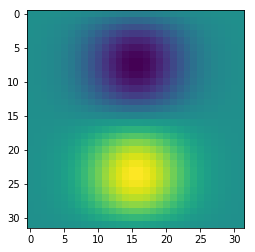

In [21]:
# %% Confirm this does something:
plt.imshow(gabor().eval())
plt.show()

In [22]:
# %% And another function which can convolve
def convolve(img, W):
    # The W matrix is only 2D
    # But conv2d will need a tensor which is 4d:
    # height x width x n_input x n_output
    if len(W.get_shape()) == 2:
        dims = W.get_shape().as_list() + [1, 1]
        W = tf.reshape(W, dims)

    if len(img.get_shape()) == 2:
        # num x height x width x channels
        dims = [1] + img.get_shape().as_list() + [1]
        img = tf.reshape(img, dims)
    elif len(img.get_shape()) == 3:
        dims = [1] + img.get_shape().as_list()
        img = tf.reshape(img, dims)
        # if the image is 3 channels, then our convolution
        # kernel needs to be repeated for each input channel
        W = tf.concat([W, W, W], axis=2)

    # Stride is how many values to skip for the dimensions of
    # num, height, width, channels
    convolved = tf.nn.conv2d(img, W,
                             strides=[1, 1, 1, 1], padding='SAME')
    return convolved

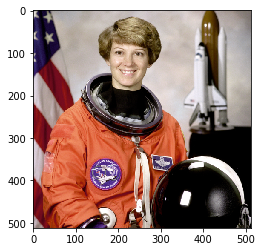

(512, 512, 3)


In [23]:
# %% Load up an image:
from skimage import data
img = data.astronaut()
plt.imshow(img)
plt.show()
print(img.shape)

In [24]:
# %% Now create a placeholder for our graph which can store any input:
x = tf.placeholder(tf.float32, shape=img.shape)

In [25]:
# %% And a graph which can convolve our image with a gabor
out = convolve(x, gabor())

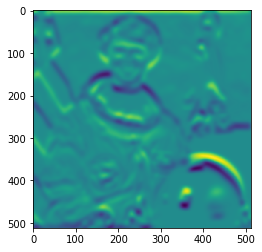

In [26]:
# %% Now send the image into the graph and compute the result
result = tf.squeeze(out).eval(feed_dict={x: img})
plt.imshow(result)
plt.show()

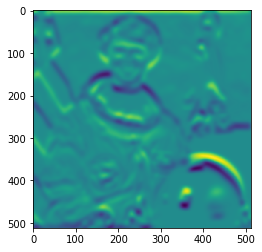

In [29]:
#alternative:
sess.close()

sess = tf.Session()
result = sess.run(tf.squeeze(out), feed_dict={x: img})
plt.imshow(result)
plt.show()